In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install keras==2.10.0
!pip install tensorflow==2.10.0
!pip install h5py==3.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 30.8 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires keras<2.10.0,>=2.9.0rc0, but you have keras 2.10.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 578.1 MB 5.7 kB/s 
     |████████████████████████████████| 5.9 MB 65.7 MB/s 
     |████████████████████████████████| 438 kB 64.0 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9

In [5]:
#!unzip /content/drive/MyDrive/pcos_classification/Data.zip -d /content/drive/MyDrive/pcos_classification/Data

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image
import io
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB2
from keras.layers import GlobalAveragePooling2D, Dropout, Dense
from keras.models import Model
from tensorflow.keras import layers
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import display, clear_output
import ipywidgets as widgets
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report
import itertools
from tensorflow.keras import layers ,models,optimizers
from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.applications.vgg19 import VGG19
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop,Adam,SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

Loading Data

In [7]:
labels = ['infected', 'notinfected']
X_train = []
Y_train  = []
X_test = []
Y_test = []
image_size=150 #sizeof image

for label in labels:
    trainPath = os.path.join('/content/drive/MyDrive/pcos_classification/Data/train',label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(label)
    
    testPath = os.path.join('/content/drive/MyDrive/pcos_classification/Data/test',label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file))
        image = cv2.resize(image, (image_size, image_size))
        X_test.append(image)
        Y_test.append(label)
    
X_train = np.array(X_train)
X_test = np.array(X_test)

100%|██████████| 98/98 [00:57<00:00,  1.69it/s]


In [8]:
print(X_train.shape)
print(X_test.shape)

(1922, 150, 150, 3)
(196, 150, 150, 3)


In [9]:
X_train, Y_train = shuffle(X_train, Y_train, random_state=10)
X_train.shape

(1922, 150, 150, 3)

Data Visualization

<ipython-input-10-7a626869507d>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(6, 6, i + 1)


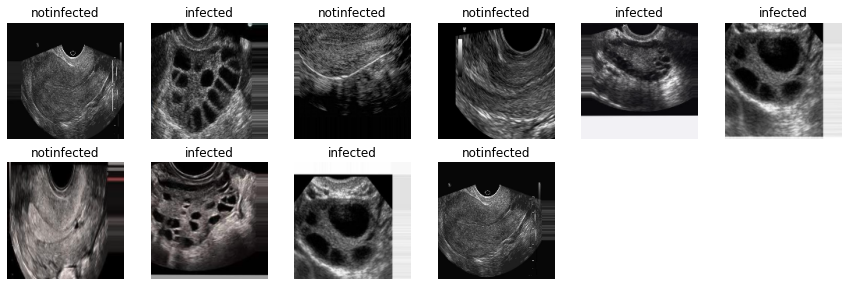

In [10]:
plt.figure(figsize=(15, 15))
class_names = Y_train
for i in range(0,10):
    for i in range(10):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(X_train[i])
        plt.title(Y_train[i])
        plt.axis("off")

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


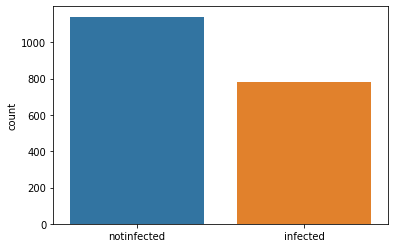

In [11]:
sns.countplot(Y_train)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


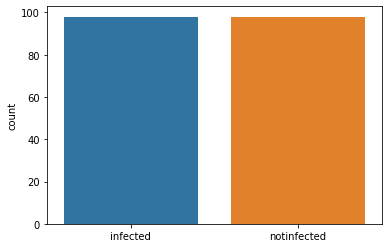

In [12]:
sns.countplot(Y_test)

In [13]:
#label encoding
y_train_ = []
for i in Y_train:
    y_train_.append(labels.index(i))
Y_train = y_train_

Y_train = tf.keras.utils.to_categorical(Y_train)

y_test_ = []
for i in Y_test:
    y_test_.append(labels.index(i))
Y_test = y_test_

Y_test = tf.keras.utils.to_categorical(Y_test)

In [14]:
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=28) #splitting data 

In [15]:
#Image augmentation
datagen = ImageDataGenerator(rescale = 1./255,
                             shear_range = 0.2,
                             zoom_range = 0.2,
                             horizontal_flip = True,
                             vertical_flip=True,
                             rotation_range=30,
                             validation_split=0.3,
                             fill_mode='nearest'
                             )

In [16]:
batch_size = 32
nb_train_samples = x_train.shape[0]
nb_validation_samples = x_val.shape[0]
print(nb_train_samples)
print(nb_validation_samples)
training_generator = datagen.flow(x_train, y_train, batch_size=batch_size)
validation_generator = datagen.flow(x_val, y_val, batch_size=batch_size)

1729
193



Resnet50

In [17]:
from tensorflow.keras.applications import resnet50
from tensorflow.keras.applications.imagenet_utils import preprocess_input

In [18]:
conv_model = resnet50.ResNet50(weights='imagenet',include_top=False,input_shape = (150,150,3))

for layer in conv_model.layers[:-3]:
    layer.trainable=False  #The role of the embedding layer is to map a category into a dense space in a way that is useful for the task

resnet_model = models.Sequential()
resnet_model.add(layers.Conv2D(32,(3,3),activation = 'relu',name = 'Conv_',input_shape = (150,150,3)))
resnet_model.add(layers.Conv2D(32,(3,3),activation = 'relu',name = 'Conv_2',padding = 'same'))
resnet_model.add(layers.Conv2D(32,(3,3),activation = 'relu',name = 'Conv_3',padding = 'same'))
resnet_model.add(layers.BatchNormalization())
resnet_model.add(layers.MaxPooling2D((2,2),name = 'max_1'))
resnet_model.add(layers.Conv2D(64,(3,3),activation = 'relu',name = 'Conv_4',padding='same'))
resnet_model.add(layers.Conv2D(64,(3,3),activation = 'relu',name = 'Conv_5',padding='same'))
resnet_model.add(layers.BatchNormalization())
resnet_model.add(layers.MaxPooling2D((2,2),name = 'max_2'))

resnet_model.add(layers.Conv2D(128,(3,3),activation='relu'))
resnet_model.add(layers.BatchNormalization())
resnet_model.add(layers.MaxPooling2D((2,2)))
resnet_model.add(layers.Conv2D(128,(3,3),activation='relu'))
resnet_model.add(layers.BatchNormalization())
resnet_model.add(layers.Flatten())
resnet_model.add(layers.Dense(512,activation = 'relu',name = 'L1',))
resnet_model.add(layers.BatchNormalization())
resnet_model.add(layers.Dense(256,activation = 'relu',name = 'L2'))
resnet_model.add(layers.BatchNormalization())
resnet_model.add(layers.Dense(256,activation = 'relu',name = 'L3'))
resnet_model.add(layers.BatchNormalization())
resnet_model.add(layers.Dense(128,activation = 'relu' ,name ='L4'))
resnet_model.add(layers.BatchNormalization())
resnet_model.add(layers.Dense(2,activation = 'softmax',name = 'output'))

94765736/94765736 [==============================] - 4s 0us/step


In [19]:
resnet_model.compile(optimizer = optimizers.SGD(learning_rate=.0001) ,
              loss='categorical_crossentropy',
              metrics=['acc'])

In [20]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_ (Conv2D)              (None, 148, 148, 32)      896       
                                                                 
 Conv_2 (Conv2D)             (None, 148, 148, 32)      9248      
                                                                 
 Conv_3 (Conv2D)             (None, 148, 148, 32)      9248      
                                                                 
 batch_normalization (BatchN  (None, 148, 148, 32)     128       
 ormalization)                                                   
                                                                 
 max_1 (MaxPooling2D)        (None, 74, 74, 32)        0         
                                                                 
 Conv_4 (Conv2D)             (None, 74, 74, 64)        18496     
                                                        

In [21]:
history1 = resnet_model.fit_generator(training_generator,
                         steps_per_epoch = nb_train_samples // batch_size,
                         epochs = 5, 
                         verbose = 1,
                         validation_data = validation_generator,
                         validation_steps = nb_validation_samples // batch_size)

<ipython-input-21-e45c2e522de0>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1 = resnet_model.fit_generator(training_generator,


Epoch 1/5
54/54 [==============================] - 22s 195ms/step - loss: 0.8827 - acc: 0.5798 - val_loss: 0.7245 - val_acc: 0.5625
Epoch 2/5
54/54 [==============================] - 10s 181ms/step - loss: 0.6205 - acc: 0.7154 - val_loss: 0.9673 - val_acc: 0.5677
Epoch 3/5
54/54 [==============================] - 10s 183ms/step - loss: 0.4516 - acc: 0.7784 - val_loss: 1.3881 - val_acc: 0.5625
Epoch 4/5
54/54 [==============================] - 10s 183ms/step - loss: 0.3687 - acc: 0.8285 - val_loss: 1.8326 - val_acc: 0.5625
Epoch 5/5
54/54 [==============================] - 10s 188ms/step - loss: 0.3060 - acc: 0.8609 - val_loss: 2.2487 - val_acc: 0.5625


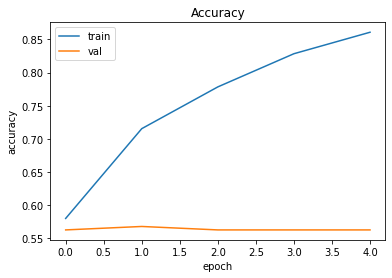

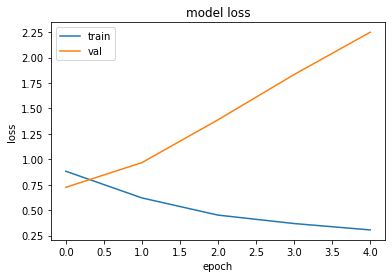

In [22]:
#accuracy and loss plot
plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

#loss plot
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

7/7 [==============================] - 1s 63ms/step


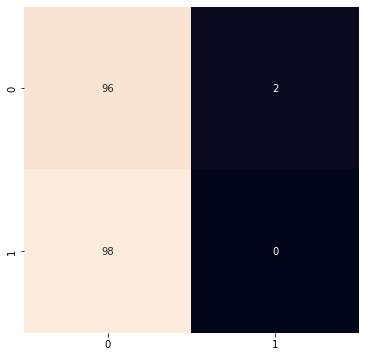

In [23]:
pred = resnet_model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(Y_test,axis=1)

cmat = confusion_matrix(y_test_new,pred)
plt.figure(figsize=(6,6))
sns.heatmap(cmat, annot = True, cbar = False);

In [24]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.49      0.98      0.66        98
           1       0.00      0.00      0.00        98

    accuracy                           0.49       196
   macro avg       0.25      0.49      0.33       196
weighted avg       0.25      0.49      0.33       196



In [25]:
from sklearn.metrics import precision_recall_fscore_support
res = []
for l in range(2):
     prec,recall,_,_ = precision_recall_fscore_support(y_test_new==l,
                                                  pred==l,
                                                  pos_label=True,average=None)
     res.append([l,recall[0],recall[1]])

pd.DataFrame(res,columns = ['class','sensitivity','specificity'])

,class,sensitivity,specificity
0,0,0.000000,0.979592
1,1,0.979592,0.000000


EfficientNet- B2

In [26]:
base_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

31790344/31790344 [==============================] - 2s 0us/step


In [27]:
model2 = base_model.output
model2 = GlobalAveragePooling2D()(model2)
model2 = Dropout(0.4)(model2)
model2 = Dense(2, activation='softmax')(model2)
model2 = Model(inputs = base_model.input, outputs=model2)

In [28]:
model2.compile(loss='categorical_crossentropy', optimizer=Adam(0.1), metrics=['accuracy'])

In [29]:
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 150, 150, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 150, 150, 3)  0           ['normalization[0][0]']      

In [30]:
history2 = model2.fit_generator(training_generator,
                         steps_per_epoch = nb_train_samples // batch_size,
                         epochs = 5, 
                         verbose = 1,
                         validation_data = validation_generator,
                         validation_steps = nb_validation_samples // batch_size)

<ipython-input-30-ace8fa9073de>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2 = model2.fit_generator(training_generator,


Epoch 1/5
54/54 [==============================] - 31s 292ms/step - loss: 6.2870 - accuracy: 0.5580 - val_loss: 9793284570349568.0000 - val_accuracy: 0.4375
Epoch 2/5
54/54 [==============================] - 13s 232ms/step - loss: 1.2227 - accuracy: 0.8468 - val_loss: 284496544.0000 - val_accuracy: 0.4375
Epoch 3/5
54/54 [==============================] - 14s 262ms/step - loss: 0.4921 - accuracy: 0.9517 - val_loss: 2726200.2500 - val_accuracy: 0.4323
Epoch 4/5
54/54 [==============================] - 13s 232ms/step - loss: 0.5393 - accuracy: 0.9352 - val_loss: 572822.8125 - val_accuracy: 0.5677
Epoch 5/5
54/54 [==============================] - 13s 236ms/step - loss: 0.1215 - accuracy: 0.9853 - val_loss: 18233.6738 - val_accuracy: 0.4375


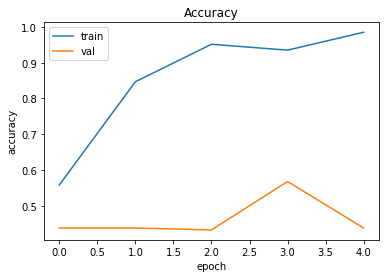

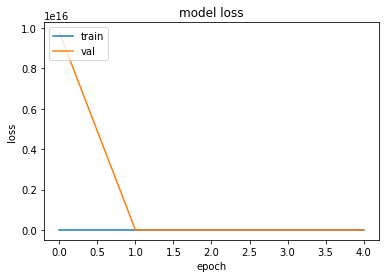

In [31]:
#accuracy and loss plot
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

#loss plot
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

7/7 [==============================] - 3s 133ms/step


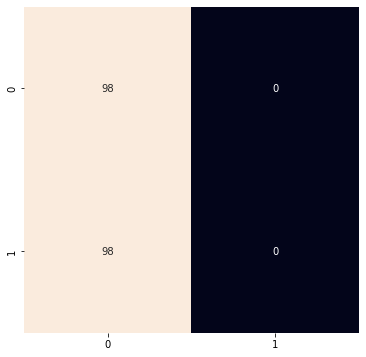

In [32]:
pred = model2.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(Y_test,axis=1)

cmat = confusion_matrix(y_test_new,pred)
plt.figure(figsize=(6,6))
sns.heatmap(cmat, annot = True, cbar = False);

In [33]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67        98
           1       0.00      0.00      0.00        98

    accuracy                           0.50       196
   macro avg       0.25      0.50      0.33       196
weighted avg       0.25      0.50      0.33       196



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
from sklearn.metrics import precision_recall_fscore_support
res = []
for l in range(2):
     prec,recall,_,_ = precision_recall_fscore_support(y_test_new==l,
                                                  pred==l,
                                                  pos_label=True,average=None)
     res.append([l,recall[0],recall[1]])

pd.DataFrame(res,columns = ['class','sensitivity','specificity'])

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,class,sensitivity,specificity
0,0,0.0,1.0
1,1,1.0,0.0


CNN Model

In [35]:
model = Sequential()
model.add(Conv2D(15, (5,5),padding='valid',activation='relu',input_shape=(150,150,3)))
model.add(MaxPooling2D(pool_size=(5,5)))
model.add(Conv2D(12, (4,4),padding='valid',activation='relu'))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Dropout(0.65))
model.add(Conv2D(8, (1,1),padding='valid',activation='relu'))
model.add(MaxPooling2D(pool_size=(1,1)))
model.add(Dropout(0.55))
model.add(Flatten())
model.add(Dense(2,activation='softmax'))

In [36]:
model.compile(optimizer='adam',loss="categorical_crossentropy",metrics=['accuracy'])


In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 146, 146, 15)      1140      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 29, 15)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 12)        2892      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 12)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 12)          0         
                                                                 
 conv2d_4 (Conv2D)           (None, 6, 6, 8)          

In [45]:
history3 = model.fit_generator(training_generator,
                         steps_per_epoch = nb_train_samples // batch_size,
                         epochs = 5, 
                         verbose = 1,
                         validation_data = validation_generator,
                         validation_steps = nb_validation_samples // batch_size)

Epoch 1/5


<ipython-input-45-36cb8bb97a7d>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history3 = model.fit_generator(training_generator,


54/54 [==============================] - 9s 164ms/step - loss: 0.1509 - accuracy: 0.9481 - val_loss: 0.0540 - val_accuracy: 1.0000
Epoch 2/5
54/54 [==============================] - 9s 163ms/step - loss: 0.1222 - accuracy: 0.9593 - val_loss: 0.0546 - val_accuracy: 0.9896
Epoch 3/5
54/54 [==============================] - 9s 160ms/step - loss: 0.1219 - accuracy: 0.9646 - val_loss: 0.0311 - val_accuracy: 1.0000
Epoch 4/5
54/54 [==============================] - 9s 163ms/step - loss: 0.1034 - accuracy: 0.9717 - val_loss: 0.0249 - val_accuracy: 1.0000
Epoch 5/5
54/54 [==============================] - 10s 176ms/step - loss: 0.0783 - accuracy: 0.9770 - val_loss: 0.0223 - val_accuracy: 0.9948


In [46]:
model.save('/content/drive/MyDrive/pcos_classification/models/cnn.h5')

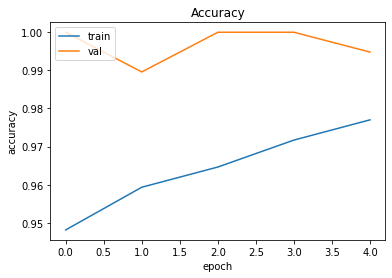

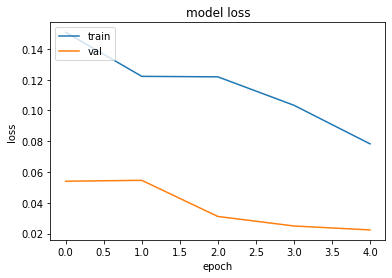

In [47]:
#accuracy and loss plot
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

#loss plot
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

7/7 [==============================] - 0s 5ms/step


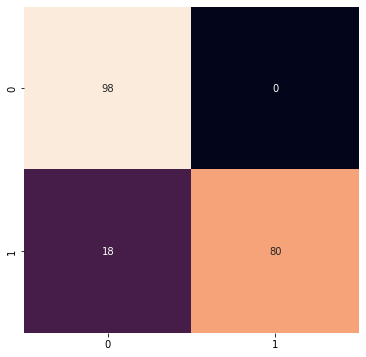

In [48]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(Y_test,axis=1)

cmat = confusion_matrix(y_test_new,pred)
plt.figure(figsize=(6,6))
sns.heatmap(cmat, annot = True, cbar = False);

In [49]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.84      1.00      0.92        98
           1       1.00      0.82      0.90        98

    accuracy                           0.91       196
   macro avg       0.92      0.91      0.91       196
weighted avg       0.92      0.91      0.91       196



In [50]:
from sklearn.metrics import precision_recall_fscore_support
res = []
for l in range(2):
     prec,recall,_,_ = precision_recall_fscore_support(y_test_new==l,
                                                  pred==l,
                                                  pos_label=True,average=None)
     res.append([l,recall[0],recall[1]])

pd.DataFrame(res,columns = ['class','sensitivity','specificity'])

,class,sensitivity,specificity
0,0,0.816327,1.000000
1,1,1.000000,0.816327
